 참조 사이트 :  
 https://www.kaggle.com/code/wangmo/self-driving-cars-road-segmentation-task/data
 https://carla.readthedocs.io/en/latest/ref_sensors/#semantic-segmentation-camera
 

주제 : Self-driving cars Road Segmentation Task

- 데이터셋 다운 받기

In [11]:
# # 1. 케글 다운
# pip install kaggle
# # 2. 케글 account 토큰 받기(계정 - API - Create New API - kaggel.json 다운 확인)
# # 3. user/.kaggle에 json파일 넣기
# # 3-1. .kaggle이 없는 경우 anaconda prompt에서 kaggle입력하여 생성하기
# # 4. 케글 위치 및 config정보 확인
# !pip show kaggle
# !kaggle config view #username에 내 아이디가 나오면 성공
# # 5. kaggle에서 희망하는 데이터 API 주소 복사 & 다운로드


Configuration values from C:\Users\user\.kaggle
- username: leticia14
- path: None
- proxy: None
- competition: None


In [13]:
# import opendatasets as od
# od.download("https://www.kaggle.com/meetnagadia/coco-cola-stock-data-19622021")

Source code downloaded to c:\Self_Study\PythonStudy\사진 분류\self-driving-cars-road-segmentation-task.ipynb


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
#Set numpy and Tensorflow random seed to mask sure experiment reproducible(only works in CPU mode).
from numpy.random import seed
seed(123)
import tensorflow 
tensorflow.random.set_seed(123)


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: '../input'

In [2]:
image_path = '../input/dataa/dataA/CameraRGB/'
mask_path = '../input/dataa/dataA/CameraSeg/'
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

Text(0.5,1,'Segmentation')

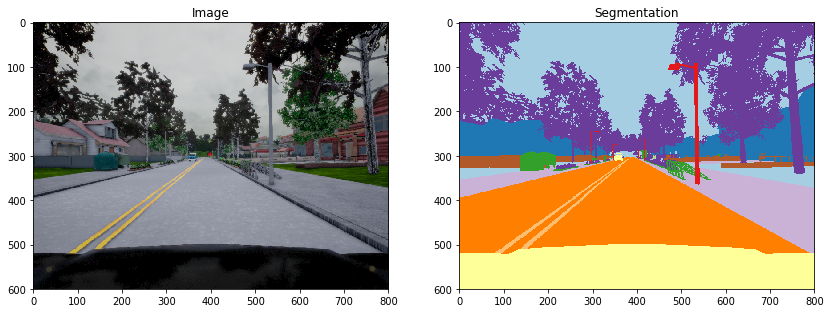

In [3]:
N = 1
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask, cmap='Paired')
arr[1].set_title('Segmentation')

## Limited by RAM, just do <font color=red>road</font> segmentation(mask == 7).

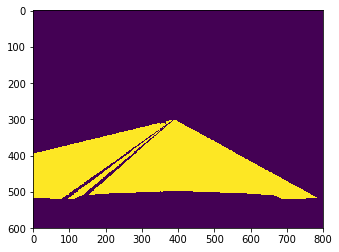

In [4]:
road = np.zeros((600, 800))
road[np.where(mask==7)[0], np.where(mask==7)[1]]=1
plt.imshow(road)

In [5]:
from tqdm import tqdm

In [ ]:
height, width = 600, 800
images = np.zeros((len(image_list), height, width, 3), dtype=np.int16)
masks = np.zeros((len(image_list), height, width, 1), dtype=np.int8)

for n in tqdm(range(len(image_list))):
    img = imageio.imread(image_list[n])
    
    mask = imageio.imread(mask_list[n])
    mask_road = np.zeros((600, 800, 1), dtype=np.int8)
    mask_road[np.where(mask==7)[0], np.where(mask==7)[1]]=1
    
    images[n] = img
    masks[n] = mask_road

 22%|██▏       | 218/1000 [00:16<01:58,  6.61it/s]

In [ ]:
plt.imshow(images[1].reshape(600, 800, 3))

In [ ]:
np.random.seed(123)
shuffle_ids = np.array([i for i in range(len(masks))])
np.random.shuffle(shuffle_ids)
train_ids = shuffle_ids[:int(len(masks)*0.8)]
val_ids = shuffle_ids[int(len(masks)*0.8):int(len(masks)*0.8+100)]
test_ids = shuffle_ids[int(len(masks)*0.8+100):]

In [ ]:
train_images, train_masks = images[train_ids], masks[train_ids]
val_images, val_masks = images[val_ids], masks[val_ids]
test_images, test_masks = images[test_ids], masks[test_ids]

In [ ]:
train_images.shape, val_images.shape, test_images.shape

## Build U-Net with subtle changes

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

In [ ]:
# Build U-Net model
input_img = Input((height, width, 3), name='img')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (u5)
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c2])
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c1])
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (c8)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c8)

model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()

In [ ]:
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-sdc-seg-v2.h5', verbose=1, save_best_only=True)
]

results = model.fit(train_images, train_masks, batch_size=16, epochs=100, callbacks=callbacks,
                    validation_data=(val_images, val_masks))

In [ ]:
model.save('final-road-seg-model-v2.h5')

In [ ]:
NUMBER = 0
my_preds = model.predict(np.expand_dims(test_images[NUMBER], 0))
my_preds = my_preds.flatten()
my_preds = np.array([1 if i >= 0.5 else 0 for i in my_preds])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(my_preds.reshape(600, 800))
ax[0].set_title('Prediction')
ax[1].imshow(test_masks[NUMBER].reshape(600, 800))
ax[1].set_title('Ground truth')

In [ ]:
NUMBER += 1
my_preds = model.predict(np.expand_dims(test_images[NUMBER], 0))
my_preds = my_preds.flatten()
my_preds = np.array([1 if i >= 0.5 else 0 for i in my_preds])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(my_preds.reshape(600, 800))
ax[0].set_title('Prediction')
ax[1].imshow(test_masks[NUMBER].reshape(600, 800))
ax[1].set_title('Ground truth')